In [3]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# !pip install pandas
# !pip install tqdm
# !pip install matplotlib
# !pip install opencv-python
# !pip install scikit-learn
# !pip install seaborn

In [4]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# Dataset class for the custom dataset
class Four4All(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def TrainResNet50(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs):

    # Define Transformations (resize, normalize, augment)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet-50 requires 224x224 input size
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])

    # Load the dataset
    train_dataset = Four4All(csv_file=data_directory+'/train/labels.csv',
                            img_dir=data_directory+'/train', transform=transform)

    val_dataset = Four4All(csv_file=data_directory+'/validation/labels.csv', 
                        img_dir=data_directory+'/validation/', transform=transform)

    num_classes = train_dataset.labels.iloc[:, 1].nunique()
    print(f"Number of classes: {num_classes}")

    # Calculate class weights for the training dataset (balanced weights) - Modification
    labels = train_dataset.labels.iloc[:, 1].values 
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Create DataLoaders for current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    # test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Load a pretrained ResNet-50 and modify the FC layer
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)  # Adjust number of classes as per your dataset
    model = model.to(device)

    # Loss function and optimizer for current config
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights here - Modification
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) #This is the same optimiser as ResEmoteNet, leading to better comparison
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    patience_counter = 0
    best_val_acc = 0

    # Training loop for current hyperparameters
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Evaluate on validation set
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model for this hyperparameter configuration
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # torch.save(model.state_dict(), 'temp_best_model.pth')
            os.makedirs("Models", exist_ok=True)
            torch.save(model.state_dict(), f'Models/ResNet50_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy for {patience_counter} epochs.")

        if patience_counter > patience:
            print("Stopping early due to lack of improvement in validation accuracy.")
            break

    print(f"Finished training with lr={lr}, batch_size={batch_size}, momentum={momentum}, weight_decay={weight_decay}")
    print(f"Best validation accuracy: {best_val_acc}\n")

In [12]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured'
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured'
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
# dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured'

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 1 #80

TrainResNet50(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs)

Using cuda device
Number of classes: 8


Epoch 1/1: 100%|██████████| 2348/2348 [06:03<00:00,  6.46it/s]


Epoch 1: Train Loss: 1.5915, Train Acc: 0.3973, Val Loss: 1.3242, Val Acc: 0.5262
Finished training with lr=0.001, batch_size=16, momentum=0.9, weight_decay=0.0001
Best validation accuracy: 0.52625



### Deriving Metrics On Testing Set 

In [36]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def TestResNet50(data_directory, model_path, batch_size=15):

    # Transform the dataset
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    test_dataset = Four4All(csv_file=data_directory+'/test/labels.csv', 
                            img_dir=data_directory+'/test', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    state_dict = torch.load(model_path, weights_only=True)
    final_fc_layer = [k for k in state_dict.keys() if 'fc' in k and 'weight' in k][-1]
    num_classes = state_dict[final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    # Load a pretrained ResNet-50 and modify the FC layer
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes).to(device)

    model.load_state_dict(state_dict)
    model.eval()

    all_preds = []
    all_labels = []

    # Iterate through test_loader to collect predictions and ground truth labels
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # Get the predicted class (assumes outputs are logits)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate lists to form single arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print the metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # (Optional) Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Number of classes: 7
Test Accuracy: 0.19035202086049544
Precision (Weighted): 0.3885419978981143
Precision (Macro): 0.23298501877694425
Precision (Micro): 0.19035202086049544
Recall (Weighted): 0.19035202086049544
Recall (Macro): 0.2264667969781187
Recall (Micro): 0.19035202086049544
F1 Score (Weighted): 0.14368045486965875
F1 Score (Macro): 0.148229661579842
F1 Score (Micro): 0.19035202086049544

Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.15      0.09        81
           1       0.15      0.04      0.06        80
           2       0.04      0.22      0.07        37
           3       0.67      0.00      0.01       592
           4       0.22      0.16      0.19       239
           5       0.20      0.67      0.31       165
           6       0.28      0.34      0.31       340

    accuracy                           0.19      1534
   macro avg       0.23      0.23      0.15      1534
weighted avg       0.39      0.19

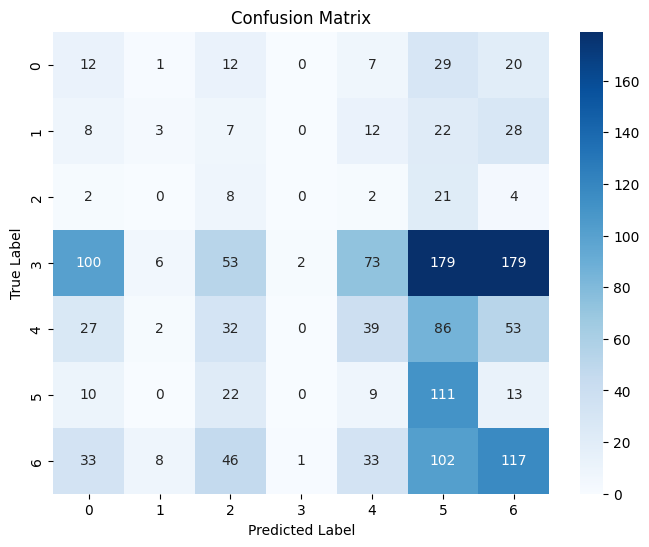

In [41]:
# dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured'
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured'
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured'

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 1 #80
model_path = f'Models/ResNet50_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth'

TestResNet50(data_directory, model_path, batch_size=15)

# Testing On Single Images

In [42]:
# import cv2
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import torch.nn.functional as F
# from PIL import Image
# from torchvision import transforms

# # Load OpenCV's Haar cascade for face detection
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# # Define transformations (same as used in training)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to match model input
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (if needed)
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# def detect_and_crop_face(image_path):
#     """Detects the largest face in an image and returns the cropped face."""
#     image = cv2.imread(image_path)  # Read image using OpenCV
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for detection

#     # Detect faces
#     faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

#     if len(faces) == 0:
#         print("No face detected, using the original image.")
#         return Image.open(image_path)  # Return the full image if no face is found

#     # Select the largest face (assuming it is the main subject)
#     x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])

#     # Crop the detected face
#     face_crop = image[y:y+h, x:x+w]

#     # Convert cropped face to PIL image
#     return Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))

# # Display the transformed image before passing it to the model
# def show_transformed_image(tensor):
#     """Convert a tensor back to a visual image and display it."""
#     tensor = tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)

#     # Undo normalization
#     mean = [0.485, 0.456, 0.406]
#     std = [0.229, 0.224, 0.225]
#     tensor = tensor * std + mean  # De-normalize
#     tensor = np.clip(tensor, 0, 1)  # Ensure values are in range [0,1]

#     plt.imshow(tensor)
#     plt.axis('off')
#     plt.show()


# for img in ['ANG', 'DIS', 'FEA', 'HAP', 'SAD', 'SUR']:
#     image_path = 'testing.jpg'#f'JAFFE_ResEmoteNet\\validation\\val_0_{img}.tiff'

#     face_image = detect_and_crop_face(image_path)

#     # Apply transformations
#     input_tensor = transform(face_image)

#     # Show the transformed face image
#     show_transformed_image(input_tensor)

#     # Add batch dimension and move to device
#     input_tensor = input_tensor.unsqueeze(0).to(device)

#     # Load model
#     model.load_state_dict(torch.load('best_resnet50_fer.pth'))  # Load best model
#     model.eval()

#     # Run inference
#     with torch.no_grad():
#         outputs = model(input_tensor)
#         probabilities = F.softmax(outputs, dim=1)
#         print(probabilities)
#         _, predicted = torch.max(outputs, 1)
#         predicted_label = predicted.item()

#     # Label mapping
#     label_map = {0: 'happy', 1: 'surprise', 2: 'sad', 3: 'anger', 4: 'disgust', 5: 'fear'}
#     emotion = label_map.get(predicted_label, "Unknown")

#     print(f"Predicted label index: {predicted_label}")
#     print(f"Predicted emotion: {emotion}")
#     break
